The data used in the final paper was generated before a random seed was added, so running this code may produce slightly different numbers.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import opencc

from sklearn.metrics.pairwise import euclidean_distances

In [52]:
NUM_COMPLEXITY_BINS = 6
NUM_BIN_SAMPLES = 200
NUM_FULL_SAMPLES = 2000
SAMPLE_SIZE = 50
FULL_SAMPLE_SIZE = 50

PERIODS = ["Oracle", "Bronze", "Seal", "Traditional", "Simplified"]
DISTINCTIVENESS_NEIGHBOURS = 20
DISTINCTIVENESS_EXAMPLES = 10

SEED = 0
random.seed(SEED)

In [53]:
root = "../data"
embeddings = pd.read_csv(f"{root}/distinctiveness/hccr_embeddings.csv", index_col=0)
embeddings["fc1_embedding"] = embeddings["fc1_embedding"].apply(eval)
embeddings = embeddings.rename({"character": "rendered_character"}, axis=1)
distinctiveness = pd.read_csv(f"{root}/distinctiveness/all_distinctiveness.csv", index_col=0)
oracle_stream_characters = set(distinctiveness[distinctiveness["period"] == "Oracle"]["simplified_character"])

# Only keep Oracle stream characters
distinctiveness = distinctiveness[distinctiveness["simplified_character"].isin(oracle_stream_characters)]
embeddings = embeddings.merge(distinctiveness[["simplified_character", "perimetric_complexity", "rendered_character", "period", "image_id"]], on=["rendered_character", "period", "image_id"])


In [57]:
embeddings = embeddings[embeddings["dataset"].isin(["hzy", "casia", "traditional"])]

Oracle
Bronze
Seal
Traditional
Simplified
Oracle
Bronze
Seal
Traditional
Simplified


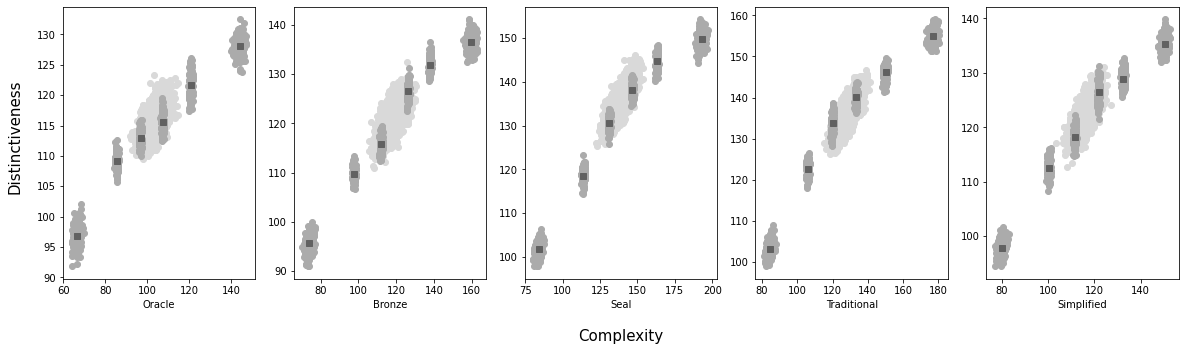

In [91]:
# Bin sampling
rows = []
for period in PERIODS:
    
    print(period)
    
    # Filter by period
    period_df = embeddings[embeddings["period"] == period]
    
    # Sort by complexity
    period_df = period_df.sort_values(by="perimetric_complexity", ascending=True).reset_index(drop=True)
    
    # Bin according to complexity
    bin_labels = list(range(NUM_COMPLEXITY_BINS))
    bins = pd.qcut(period_df["perimetric_complexity"], q=NUM_COMPLEXITY_BINS, labels=bin_labels)
    period_df["perimetric_complexity_bin"] = bins
    
    for bin_label, bin_df in period_df.groupby("perimetric_complexity_bin"):
        for i in range(NUM_BIN_SAMPLES):
            bin_sample = bin_df.sample(n=SAMPLE_SIZE, random_state=i)
            sample_avg_complexity = np.mean(bin_sample["perimetric_complexity"])
            
            distances = euclidean_distances(bin_sample["fc1_embedding"].tolist())
            distinctiveness_scores = []
            for d in distances:
                distinctiveness_scores.append(np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1]))
            sample_avg_distinctiveness = np.mean(distinctiveness_scores)
            
            rows.append((period, bin_label, i, sample_avg_complexity, sample_avg_distinctiveness))
            
bin_df = pd.DataFrame(rows, columns=["period", "bin", "sample_num", "sample_average_complexity", "sample_average_distinctiveness"])


# Full sampling
rows = []
for period in PERIODS:
    
    print(period)
    
    period_df = embeddings[embeddings["period"] == period]
    
    for i in range(NUM_FULL_SAMPLES):
        full_sample = period_df.sample(n=FULL_SAMPLE_SIZE, random_state=i)
        sample_avg_complexity = np.mean(full_sample["perimetric_complexity"])
        
        distances = euclidean_distances(full_sample["fc1_embedding"].tolist())
        distinctiveness_scores = []
        for d in distances:
            distinctiveness_scores.append(np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1]))
        sample_avg_distinctiveness = np.mean(distinctiveness_scores)
        
        rows.append((period, i, sample_avg_complexity, sample_avg_distinctiveness))
        
full_df = pd.DataFrame(rows, columns=["period", "sample_num", "sample_average_complexity", "sample_average_distinctiveness"])


# Plot figure
fig, axes = plt.subplots(1,len(PERIODS),figsize=(20,5))

for i, period in enumerate(PERIODS):
    period_bin_df = bin_df[bin_df["period"] == period]
    period_full_df = full_df[full_df["period"] == period]
    
    # Calculate median points for each bin
    bin_complexity_medians = [np.median(bdf["sample_average_complexity"]) for _, bdf in period_bin_df.groupby("bin")]
    bin_distinctiveness_medians = [np.median(bdf["sample_average_distinctiveness"]) for _, bdf in period_bin_df.groupby("bin")]
    
    axes[i].scatter(x=period_full_df["sample_average_complexity"], y=period_full_df["sample_average_distinctiveness"], color="#d9d9d9")
    axes[i].scatter(x=period_bin_df["sample_average_complexity"], y=period_bin_df["sample_average_distinctiveness"], color="#ababab")

    axes[i].set_xlabel(period)
    axes[i].set_ylabel("")

    axes[i].plot(bin_complexity_medians, bin_distinctiveness_medians, "s", color="#616161")

axes[0].set_title("Distinctiveness", fontsize=15, rotation="vertical", x=-0.25, y=0.3)
axes[2].set_title("Complexity", fontsize=15, y=-0.25)

bin_df.to_csv(f"{root}/distinctiveness/bin_complexity_samples.csv")
full_df.to_csv(f"{root}/distinctiveness/full_complexity_samples.csv")

Oracle
Bronze
Seal
Traditional
Simplified


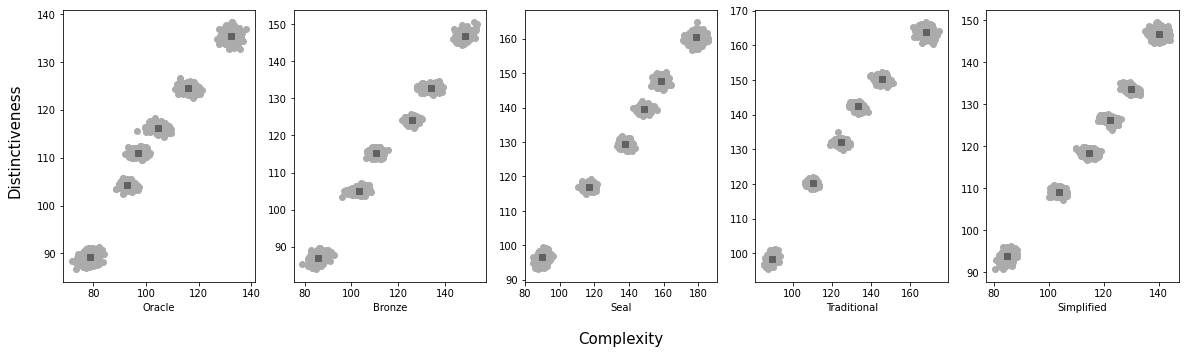

In [101]:
# Bin sampling
rows = []
for period in PERIODS:
    
    print(period)
    
    # Filter by period
    period_df = embeddings[embeddings["period"] == period].copy()
    distances = euclidean_distances(period_df["fc1_embedding"].tolist())
    distinctiveness_scores = []
    for d in distances:
        distinctiveness_scores.append(np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1]))
    period_df["distinctiveness"] = distinctiveness_scores
    
    # Sort by distinctiveness
    period_df = period_df.sort_values(by="distinctiveness", ascending=True).reset_index(drop=True)
    
    # Bin according to distinctiveness
    bin_labels = list(range(NUM_COMPLEXITY_BINS))
    bins = pd.qcut(period_df["distinctiveness"], q=NUM_COMPLEXITY_BINS, labels=bin_labels)
    period_df["distinctiveness_bin"] = bins
    
    for bin_label, bin_df in period_df.groupby("distinctiveness_bin"):
        for i in range(NUM_BIN_SAMPLES):
            bin_sample = bin_df.sample(n=SAMPLE_SIZE, random_state=i)
            sample_avg_complexity = np.mean(bin_sample["perimetric_complexity"])
            
            distances = euclidean_distances(bin_sample["fc1_embedding"].tolist())
            distinctiveness_scores = []
            for d in distances:
                distinctiveness_scores.append(np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1]))
            sample_avg_distinctiveness = np.mean(distinctiveness_scores)
            
            rows.append((period, bin_label, i, sample_avg_complexity, sample_avg_distinctiveness))
            
bin_df = pd.DataFrame(rows, columns=["period", "bin", "sample_num", "sample_average_complexity", "sample_average_distinctiveness"])

# Plot figure
fig, axes = plt.subplots(1,len(PERIODS),figsize=(20,5))

for i, period in enumerate(PERIODS):
    period_bin_df = bin_df[bin_df["period"] == period]
    
    # Calculate median points for each bin
    bin_complexity_medians = [np.median(bdf["sample_average_complexity"]) for _, bdf in period_bin_df.groupby("bin")]
    bin_distinctiveness_medians = [np.median(bdf["sample_average_distinctiveness"]) for _, bdf in period_bin_df.groupby("bin")]
    
    axes[i].scatter(x=period_bin_df["sample_average_complexity"], y=period_bin_df["sample_average_distinctiveness"], color="#ababab")

    axes[i].set_xlabel(period)
    axes[i].set_ylabel("")

    axes[i].plot(bin_complexity_medians, bin_distinctiveness_medians, "s", color="#616161")

axes[0].set_title("Distinctiveness", fontsize=15, rotation="vertical", x=-0.25, y=0.3)
axes[2].set_title("Complexity", fontsize=15, y=-0.25)

bin_df.to_csv(f"{root}/distinctiveness/bin_distinctiveness_samples.csv")

In [ ]:
rows = []
SAMPLE_SIZES = [50,100,200,350,500]
for sample_size in SAMPLE_SIZES:
    print(sample_size)
    for period in PERIODS:

        print(period)

        period_df = embeddings[embeddings["period"] == period]

        for i in range(NUM_FULL_SAMPLES):
            full_sample = period_df.sample(n=sample_size, random_state=i)
            sample_avg_complexity = np.mean(full_sample["perimetric_complexity"])

            distances = euclidean_distances(full_sample["fc1_embedding"].tolist())
            distinctiveness_scores = []
            for d in distances:
                distinctiveness_scores.append(np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1]))
            sample_avg_distinctiveness = np.mean(distinctiveness_scores)

            rows.append((sample_size, period, i, sample_avg_complexity, sample_avg_distinctiveness))

50
Oracle
Bronze
Seal
Traditional
Simplified


In [ ]:
sample_df = pd.DataFrame(rows, columns=["sample_size", "period", "sample_num", "sample_avg_complexity", "sample_avg_distinctiveness"])

Oracle
Bronze
Seal
Traditional
Simplified


<AxesSubplot:xlabel='period', ylabel='distinctiveness'>

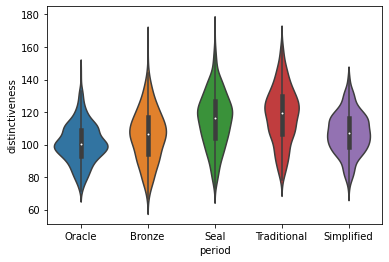

In [79]:
rows = []
for period in PERIODS:

    print(period)

    period_df = embeddings[(embeddings["period"] == period) & (embeddings["dataset"].isin(["hzy", "casia", "traditional"]))]

    full_sample = period_df
    sample_avg_complexity = np.mean(full_sample["perimetric_complexity"])

    distances = euclidean_distances(full_sample["fc1_embedding"].tolist())
    for i, d in enumerate(distances):
        rows.append((period, full_sample.iloc[i]["rendered_character"], np.mean(sorted(d)[1:DISTINCTIVENESS_NEIGHBOURS+1])))

oracle_distinctiveness = pd.DataFrame(rows, columns=["period", "character", "distinctiveness"])
sns.violinplot(x="period", y="distinctiveness", data=oracle_distinctiveness)

In [80]:
for p, pdf in distinctiveness.groupby("period"):
    print(p, pdf.shape)

Bronze (517, 9)
Oracle (651, 9)
Seal (618, 9)
Simplified (1944, 9)
Traditional (3815, 9)


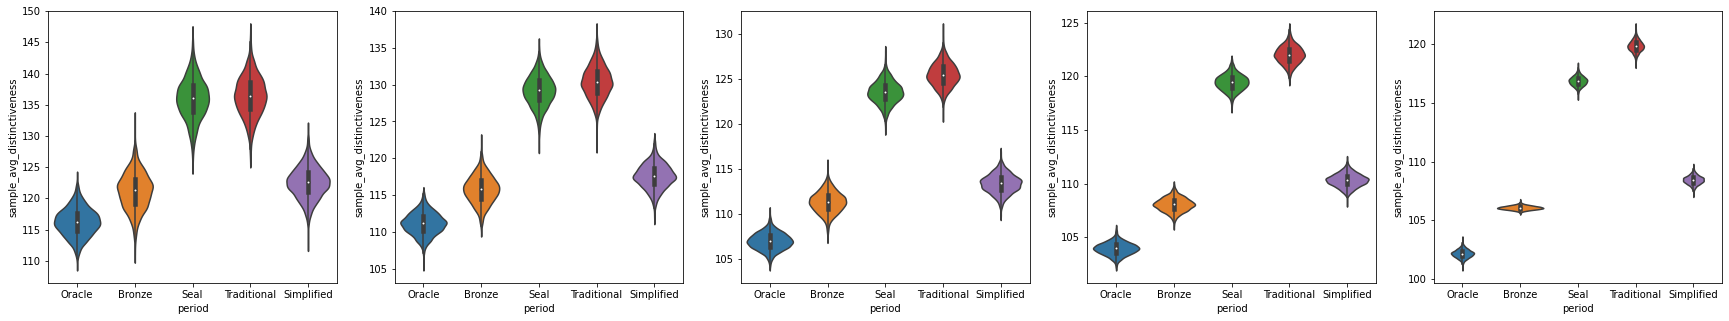

In [81]:
fig, axes = plt.subplots(1,5,figsize=(30,5))

for i, ss in enumerate(SAMPLE_SIZES):
    sns.violinplot(x="period", y="sample_avg_distinctiveness", data=sample_df[sample_df["sample_size"] == ss], ax=axes[i])
    #axes[i].set_xlabel(f"sample size = {ss}")

In [82]:
rows = []
for ss, sdf in sample_df.groupby("sample_size"):
    for p in PERIODS:
        pdf = sdf[sdf["period"] == p]
        rows.append((ss, p, np.mean(pdf["sample_avg_distinctiveness"]), np.std(pdf["sample_avg_distinctiveness"])))
avg_sample_df = pd.DataFrame(rows, columns=["sample_size", "period", "average_sample_distinctiveness", "std_sample_distinctiveness"])

<AxesSubplot:xlabel='sample_size', ylabel='std_sample_distinctiveness'>

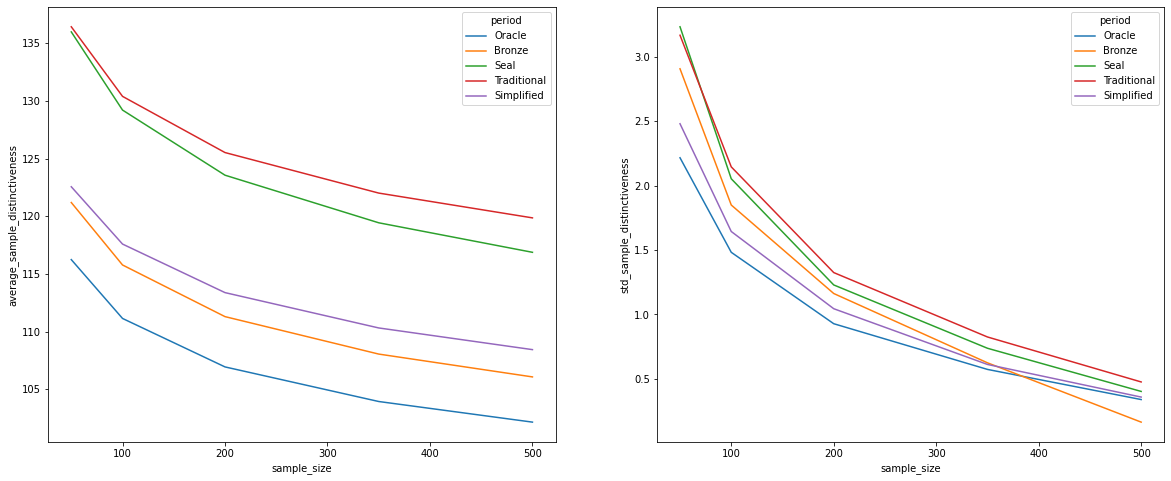

In [83]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
sns.lineplot(x="sample_size", y="average_sample_distinctiveness", hue="period", data=avg_sample_df, ax=axes[0])
sns.lineplot(x="sample_size", y="std_sample_distinctiveness", hue="period", data=avg_sample_df, ax=axes[1])

In [84]:
bin_df.to_csv(f"{root}/distinctiveness/bin_distinctiveness_samples.csv")
full_df.to_csv(f"{root}/distinctiveness/full_distinctiveness_samples.csv")